In [1]:
from tarfile import data_filter

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from iprocessor import add_day_name_column, add_date_name_column, smooth_sundays_rolling_w7_l

#### the python script iprocessor, smoothes the data by implementing moving average

## there is need for 
- parameters
- initialization for the compartments

In [2]:
# Sample parameters,
contacts = 2.0
transmission_prob = 0.3649
reducing_transmission = 0.764
exposed_period = 5.2  #
asymptomatic_period = 7
infectious_period = 3.7
isolated_period = 11  # 11,23
prob_asymptomatic = 0.2
prob_quarant_inf = 0.05
test_asy = 0.171
dev_symp = 0.125
mortality_isolated = 0.002
mortality_infected = 0.01

In [3]:
total_population = 82_000_000  # Total number of individuals
E0 = 2026.25
A0 = 3798
I0 = 376.4
F0 = 2255
R0 = 170204
D0 = 9060
S0 = total_population - E0 - A0 - I0 - F0 - R0 - D0
initial_conditions = [S0, E0, A0, I0, F0, R0, D0]

### Dataframe

In [4]:
df = pd.read_csv(r'German_case_period_may_aug.csv')

In [5]:
#Convert 'Date' column to datetime format----------------------------------------------------------------------
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Modification------------------------------------------------------------------------------
# Add the 'days' column
df = add_day_name_column(df)
df = add_date_name_column(df)
# second modification with w7_l-----------------------------------------------------------------------------
df_observed = smooth_sundays_rolling_w7_l(df)
df_observed
# -----------------------------------------------------------------------------------------------------

,Date,Confirmed,Deaths,Recovered,n_confirmed,n_death,n_recovered,Infection_case,date_name,days,rolling_mean_r,rolling_mean_c,rolling_mean_d
0,2020-05-01,166468,8602,157866,428.333333,16.000000,412.333333,915,Friday,1,412.333333,428.333333,16.000000
1,2020-05-02,167160,8626,158534,529.250000,22.750000,506.500000,846,Saturday,2,506.500000,529.250000,22.750000
2,2020-05-03,167753,8650,159103,602.600000,25.800000,576.800000,805,Sunday,3,576.800000,602.600000,25.800000
3,2020-05-04,168585,8693,159892,654.666667,25.833333,628.833333,607,Monday,4,628.833333,654.666667,25.833333
4,2020-05-05,169481,8731,160750,682.000000,27.285714,654.714286,447,Tuesday,5,654.714286,682.000000,27.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2020-07-28,210338,9412,200926,679.285714,4.285714,675.000000,563,Tuesday,89,675.000000,679.285714,4.285714
89,2020-07-29,211114,9418,201696,694.000000,6.000000,688.000000,919,Wednesday,90,688.000000,694.000000,6.000000
90,2020-07-30,211868,9423,202445,709.285714,5.714286,703.571429,940,Thursday,91,703.571429,709.285714,5.714286
91,2020-07-31,212712,9438,203274,749.833333,6.000000,743.833333,996,Friday,92,743.833333,749.833333,6.000000


In [127]:
df_observed=df_observed[19:]

In [158]:
# Taking 'days' time column from dataframe
t_fit_base = np.array(df_observed['days'])-20
print(t_fit_base)
tmax_base = len(t_fit_base)
print(f'{tmax_base}  time_base')
#time
t_fit_0 = np.zeros((tmax_base,2))
t_fit_0[:,0] = t_fit_base
t_fit_0[:,1] = 1
#
t_fit_1 = np.zeros((tmax_base,2))
t_fit_1[:,0] = t_fit_base
t_fit_1[:,1] = 0
#
t_fit = np.r_[t_fit_0,t_fit_1]
x= np.r_[t_fit_0,t_fit_1]
print(f'{len(t_fit)}   t_fit')
#
tmax = len(t_fit)


# for t_eval in the solve_ivp
times = np.linspace(1,tmax,tmax+100)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]
74  time_base
148   t_fit


### derivative equation for the flowchart

In [159]:
def derivative_rhs(x, X, contacts, transmission_prob, total_population, reducing_transmission,
                   exposed_period, asymptomatic_period, infectious_period, isolated_period,
                   prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected):
    S, E, A, I, F, R, D = X
    derivS = - contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population
    derivE = contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population - E / exposed_period
    derivA = prob_asymptomatic * E / exposed_period - A / asymptomatic_period
    derivI = (
                         1 - prob_asymptomatic) * E / exposed_period + dev_symp * A / asymptomatic_period - I / infectious_period  # +
    derivF = prob_quarant_inf * I / infectious_period - F / isolated_period + test_asy * A / asymptomatic_period  # prob_isolated_asy*A/asymptomatic_period
    derivR = (1 - prob_quarant_inf - mortality_infected) * I / infectious_period + (
                1 - mortality_isolated) * F / isolated_period + (
                         1 - dev_symp - test_asy) * A / asymptomatic_period  # (1-prob_isolated_asy)*A / asymptomatic_period
    derivD = (mortality_infected) * I / infectious_period + mortality_isolated * F / isolated_period
    return [derivS, derivE, derivA, derivI, derivF, derivR, derivD]

In [160]:
def seaifrd_model_tmax(tmax, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                  exposed_period, asymptomatic_period, infectious_period, isolated_period,
                  prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected):
    def derivative(x, initial_conditions):
        return derivative_rhs(x, initial_conditions, contacts, transmission_prob, total_population,
                              reducing_transmission,
                              exposed_period, asymptomatic_period, infectious_period,
                              isolated_period, prob_asymptomatic,
                              prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

    tmax = int(tmax)
    times = np.linspace(0,tmax,tmax+1)
    solution = solve_ivp(derivative, (0, tmax), initial_conditions, method='RK45',t_eval=times)
    #print(solution)
    return solution  # .y.flatten()

In [161]:
def seaifrd_model(x, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                  exposed_period, asymptomatic_period, infectious_period, isolated_period,
                  prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected):
    def derivative(x, initial_conditions):
        return derivative_rhs(x, initial_conditions, contacts, transmission_prob, total_population,
                              reducing_transmission,
                              exposed_period, asymptomatic_period, infectious_period,
                              isolated_period, prob_asymptomatic,
                              prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

    
    solution = solve_ivp(derivative, (0, tmax), initial_conditions, method='RK45',t_eval=times)
    #print(solution)
    return solution  # .y.flatten()

In [162]:
contacts = 2
transmission_prob = 0.3
total_population = 82000000
reducing_transmission = 0.55
exposed_period = 5.2
asymptomatic_period = 7
infectious_period = 3.7
isolated_period = 12
prob_asymptomatic = 0.34
prob_quarant_inf = 0.9303
test_asy = 0.271
dev_symp = 0.125
mortality_isolated = 0.02
mortality_infected = 0.1

# Solve the model
#t = t[:len(t)//2] #sorted(set(t))
solution = seaifrd_model_tmax(2, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                         exposed_period, asymptomatic_period, infectious_period, isolated_period,
                         prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)
solution.y[6]

array([9060.        , 9077.27786342, 9102.11877099])

In [235]:
def objective_function_recoverd_dead(X,isolated_period):
    t = X[:, 0]
    mode = X[:, 1]
    tmax = max(t)
    # Model parameters (could be passed as arguments or fixed here)
    contacts = 1.1
    transmission_prob = 0.3
    total_population = 82_000_000
    reducing_transmission = 0.55
    exposed_period = 5.2
    asymptomatic_period = 7
    infectious_period = 3.7
    #isolated_period = 12
    prob_asymptomatic = 0.34
    prob_quarant_inf = 0.9303
    test_asy = 0.271
    dev_symp = 0.125
    mortality_isolated = 0.02
    mortality_infected = 0.1

    contacts = 0.5
    transmission_prob = 0.3
    total_population = 82000000
    reducing_transmission = 0.55
    exposed_period = 5.2
    asymptomatic_period = 7
    infectious_period = 3.7
    #isolated_period = 12
    prob_asymptomatic = 0.34
    prob_quarant_inf = 0.9303
    test_asy = 0.271
    dev_symp = 0.125
    mortality_isolated = 0.02
    mortality_infected = 0.1

    # Solve the model
    #t = t[:len(t)//2] #sorted(set(t))
    solution = seaifrd_model_tmax(tmax, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                             exposed_period, asymptomatic_period, infectious_period, isolated_period,
                             prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

    #print(solution)
    time = solution.t
    recovered = solution.y[5]
    #recovered = np.concatenate((recovered,recovered))
    dead = solution.y[6]
    #dead = np.concatenate((dead,dead))
    retval = []
    #print(recovered.shape)
    #retval = np.where(mode, recovered, dead)
    for t,mode in zip(t,mode):
        if mode:
            retval.append(recovered[int(t)])
        else:
            retval.append(dead[int(t)])
    return np.array(retval)


In [236]:
# here we have to make the length for the recovered and the dead twice!

In [237]:
data_recovered = np.ones((df_observed['n_recovered'].size,2))
data_recovered[:,0] = df_observed['n_recovered']
#
data_dead = np.zeros((df_observed['n_death'].size,2))
data_dead[:,0] = df_observed['n_death']
recovered_dead = np.r_[data_recovered,data_dead]
print(len(recovered_dead))
print(recovered_dead.shape)

148
(148, 2)


In [238]:
recovered_dead = np.r_[df_observed['n_recovered'],df_observed['n_death']]
recovered_dead.shape

(148,)

In [239]:
#recovered_dead = np.concatenate((df_observed['n_death'],df_observed['n_recovered']))
#print(len(recovered_dead))

In [240]:
### Calling curve_fit Function

In [241]:
print(recovered_dead.shape)
print(t_fit.shape)
t_fit

(148,)
(148, 2)


array([[ 0.,  1.],
       [ 1.,  1.],
       [ 2.,  1.],
       [ 3.,  1.],
       [ 4.,  1.],
       [ 5.,  1.],
       [ 6.,  1.],
       [ 7.,  1.],
       [ 8.,  1.],
       [ 9.,  1.],
       [10.,  1.],
       [11.,  1.],
       [12.,  1.],
       [13.,  1.],
       [14.,  1.],
       [15.,  1.],
       [16.,  1.],
       [17.,  1.],
       [18.,  1.],
       [19.,  1.],
       [20.,  1.],
       [21.,  1.],
       [22.,  1.],
       [23.,  1.],
       [24.,  1.],
       [25.,  1.],
       [26.,  1.],
       [27.,  1.],
       [28.,  1.],
       [29.,  1.],
       [30.,  1.],
       [31.,  1.],
       [32.,  1.],
       [33.,  1.],
       [34.,  1.],
       [35.,  1.],
       [36.,  1.],
       [37.,  1.],
       [38.,  1.],
       [39.,  1.],
       [40.,  1.],
       [41.,  1.],
       [42.,  1.],
       [43.,  1.],
       [44.,  1.],
       [45.,  1.],
       [46.,  1.],
       [47.,  1.],
       [48.,  1.],
       [49.,  1.],
       [50.,  1.],
       [51.,  1.],
       [52.,

In [242]:
#t_end = df_observed['days'].iloc[-1]
#print(f't_end = {(t_end)}, t_fit = {len(t_fit)}')
# Create a sequence from 0 to t_end
#t_fit = np.arange(0, 2*tmax, 1)

popt, pcov = curve_fit(objective_function_recoverd_dead, t_fit, recovered_dead)


In [243]:
popt

array([1.02823575e+08])

In [244]:
perr_r_d = np.sqrt(np.diag(pcov))
perr_r_d

array([2.62677862e+14])

In [245]:
t_fit

array([[ 0.,  1.],
       [ 1.,  1.],
       [ 2.,  1.],
       [ 3.,  1.],
       [ 4.,  1.],
       [ 5.,  1.],
       [ 6.,  1.],
       [ 7.,  1.],
       [ 8.,  1.],
       [ 9.,  1.],
       [10.,  1.],
       [11.,  1.],
       [12.,  1.],
       [13.,  1.],
       [14.,  1.],
       [15.,  1.],
       [16.,  1.],
       [17.,  1.],
       [18.,  1.],
       [19.,  1.],
       [20.,  1.],
       [21.,  1.],
       [22.,  1.],
       [23.,  1.],
       [24.,  1.],
       [25.,  1.],
       [26.,  1.],
       [27.,  1.],
       [28.,  1.],
       [29.,  1.],
       [30.,  1.],
       [31.,  1.],
       [32.,  1.],
       [33.,  1.],
       [34.,  1.],
       [35.,  1.],
       [36.,  1.],
       [37.,  1.],
       [38.,  1.],
       [39.,  1.],
       [40.,  1.],
       [41.,  1.],
       [42.,  1.],
       [43.,  1.],
       [44.,  1.],
       [45.,  1.],
       [46.,  1.],
       [47.,  1.],
       [48.,  1.],
       [49.,  1.],
       [50.,  1.],
       [51.,  1.],
       [52.,

In [251]:
f = objective_function_recoverd_dead(t_fit,12)
obj_recovered = f[:len(t_fit)//2]
obj_dead = f[len(t_fit)//2:]


In [252]:
f

array([170204.        , 170697.69125947, 171165.81135316, 171613.9293934 ,
       172045.96661899, 172465.25073062, 172874.21585038, 173274.21092242,
       173666.35374545, 174051.60394156, 174430.49635099, 174803.10364325,
       175169.49698621, 175529.78401021, 175884.08347153, 176232.23274299,
       176573.94049141, 176908.99014622, 177237.23935217, 177558.61996932,
       177873.11617774, 178180.54196358, 178480.69974722, 178773.45562378,
       179058.72639207, 179336.4795546 , 179606.73331757, 179869.55659086,
       180124.98241521, 180372.96452135, 180613.54054212, 180846.76737049,
       181072.72062252, 181291.49463739, 181503.20247737, 181707.97592783,
       181905.96549724, 182097.30747237, 182282.10122005, 182460.48551019,
       182632.60447178, 182798.606878  , 182958.64614618, 183112.8803378 ,
       183261.47215853, 183404.5889582 , 183542.40273079, 183675.08779861,
       183802.77540917, 183925.59847838, 184043.70351568, 184157.24064474,
       184266.36360341, 1

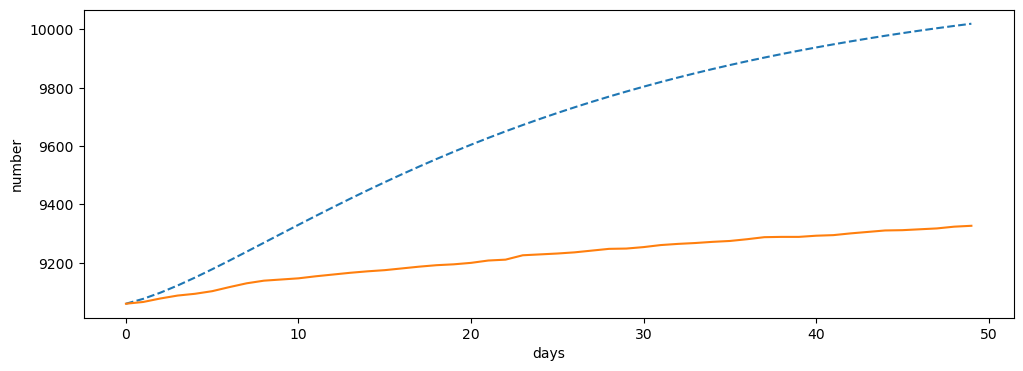

In [253]:
t = t_fit[:len(t_fit)//2,0]

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
n=50
t=t[:n]
obj_d=obj_dead[:n]
dfo = df_observed['Deaths'][:n]
plt.plot(t, obj_d, '--')
plt.plot(t,dfo)
ax.set_xlabel('days')
ax.set_ylabel('number')
plt.show()

In [234]:
obj_dead

array([9060.        , 9076.89677822, 9099.34660198, 9126.78772008,
       9158.64488755, 9194.47656814, 9233.92240245, 9276.5712213 ,
       9322.1013123 , 9370.25231374, 9420.81382497, 9473.57936229,
       9528.39304125, 9585.12273933, 9643.65526261])